# CUDA LAB - Variational Autoencoders

## Required Libraries

In [1]:
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

## Experience with the assignment: 
### 1) Initially it caused a lot of problem with dimensions of conv layers and had to revisit CNNs :)
### 2) Adding a bottleneck and changing its dimension from 2 to 10 caused a liitle trouble with interpolations but was resolved somehow.
### 3) Atleast finishing the required parts of the assignment gave me a better undestanding of them which was really needed.
### 4) I regret not doing more experimentations with layers and bottleneck size for better results but I tried playing with some conv layers and this one gave better results than others. 

## Making directories to store reconstructed images¶

In [2]:
if not os.path.exists("imgs"):
    os.makedirs("imgs")
if not os.path.exists("imgs/vanilla_dae"):
    os.makedirs("imgs/vanilla_dae")
if not os.path.exists("imgs/vanilla_vae"):
    os.makedirs("imgs/vanilla_vae")

## Keeping the original image size of 32x32

In [6]:
# Downloading and Loading Dataset
mnist_tf = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Pad(2)
    ])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=mnist_tf,download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=mnist_tf,download=True)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
# Fitting data loaders for iterating
B_SIZE = 64

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=B_SIZE, 
                                           shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=B_SIZE,
                                          shuffle=False)

## Helper Code from session 6

In [9]:
def get_act(act_name):
    """ Gettign activation given name """
    assert act_name in ["ReLU", "Sigmoid", "Tanh"]
    activation = getattr(nn, act_name)
    return activation()
    
def get_dropout(drop_p):
    """ Getting a dropout layer """
    if(drop_p):
        drop = nn.Dropout(p=drop_p)
    else:
        drop = nn.Identity()
    return drop

class Reshape(nn.Module):
    """ Module for reshaping a tensor"""
    def __init__(self, size):
        """ Module initializer"""
        super().__init__()
        self.size = size
        
    def forward(self,x):
        """ Rehaping channel spatial dimension"""
        y = x.view(-1, *self.size)
        return y

In [10]:
def train_model(model, optimizer, scheduler, criterion, train_loader,
                valid_loader, num_epochs, savepath):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    loss_iters = []
    
    for epoch in range(num_epochs):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        log_epoch = (epoch % 5 == 0 or epoch == num_epochs - 1)
        loss = eval_model(
                model=model, eval_loader=valid_loader, criterion=criterion,
                device=device, epoch=epoch, savefig=log_epoch, savepath=savepath
            )
        val_loss.append(loss)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device
            )
        scheduler.step(val_loss[-1])
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters
        
        if(log_epoch):
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters


def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f


def set_random_seed(random_seed=None):
    """
    Using random seed for numpy and torch
    """
    if(random_seed is None):
        random_seed = CONFIG["random_seed"]
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    return


def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

## First try of autoencoder(Raw code):
### At this point I was just figuring out how to work with conv layers and ConvTranspose layers. The bottleneck and figuring out the dimensions were a problem initially for me but soon I figured out how it was going down.

In [11]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        self.fc_mu = nn.Linear(in_features=32*3*3, out_features=2)
        self.fc_logvar = nn.Linear(in_features=32*3*3, out_features=2)
        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=0) # -> N, 64, 1, 1
        )
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, 2)
        )
        #self.fc1 = nn.Linear(h_dim, z_dim)
        #self.fc2 = nn.Linear(h_dim, z_dim)
        
        self.decoder_lin = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )
        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3,stride=2, output_padding=0), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=0, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )
        
    def reparameterize(self, mu, log_var):
        """ Reparametrization trick"""
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)  # random sampling happens here
        z = mu + std * eps
        return z
    
    def forward(self, x):
        x = self.encoder(x)
        #print("encode",x.shape)
        x = self.flatten(x)
        #print("encode flaten",x.shape)
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        x = self.encoder_lin(x)
        #print("encode lin",x.shape)
        
        #reparametrization trick
        z = self.reparameterize(mu, log_var)
        #print("z",z.shape)
        x = self.decoder_lin(z)
        #print("decode lin",x.shape)
        x = self.unflatten(x)
        #print(x.shape)
        decoded = self.decoder(x)
        #print(x.shape)
        return decoded, (z, mu, log_var)

# Main Code:
## This code's structure is taken from https://colab.research.google.com/drive/1SqN6ruqdmWg_Y7rd_S_n-bKTtCACDKkr?usp=drive_open
## However, the main task was getting the dimensions correct in all the layers which has been done with following the formulae for both conv and convtranspose layers.
### Reason for going for this structure: As I searched for autoencoders, the class structure was used at various sites and it looked clean with every function properly defined unlike the raw code you saw earlier above which had all the functionality as this code but is definitely not a clean coding practice.

# Comparison with the VAE from session 6:
## As I mentioned above, working with conv and convtranspose layers was tricky as one needs to be very careful with the dimensions of the tensors. Also, the number of parameters of linear vae was 608516 and for cnn vae were 1597495. However, this number seemed not that relevant to me as it depends on how many layers and dimensions one chooses for better results depending on the size of images. 
## Also, cnn vae is a better choice when working with images

In [12]:
class Flatten(nn.Module):
    def forward(self, input):
#       print(input.shape)
        #print(input.size(0))
        return input.view(input.size(0), -1)

class size(nn.Module):
    def forward(self,input):
    #print(input.shape)
        return(input)
  

      
      


In [13]:
class UnFlatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 256, 4, 4)   #CHANGE

In [51]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, z_dim=10):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 16, kernel_size=2, stride=2,padding=2), #--256x16x18x18
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1,padding=1), #--128x16x18x18
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=2, stride=2,padding=2),  #--128x32x11x11
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1,padding=1), #--128x16x11x11
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2, stride=1,padding=2),   #--128x64x14x14
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1,padding=1), #--128x16x14x14
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2,padding=1),   #--128x128x7x7
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1,padding=1), #--128x16x7x7
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2,padding=1),   #--128x256x4x4
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1,padding=1), #--128x16x4x4
            nn.ReLU(),
            #nn.Conv2d(256, 512, kernel_size=3, stride=2,padding=1),   #--128x512x4x4
            #nn.ReLU(),
            Flatten()  
        )
        
        self.fc1 = nn.Linear(256*4*4, z_dim) #CHANGE
        self.fc2 = nn.Linear(256*4*4, z_dim) #CHANGE
        self.fc3 = nn.Linear(z_dim, 256*4*4) #CHANGE
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(256, 256, kernel_size=1, stride=1), #128x256x4x4
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=1), #128x256x5x5
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=1, stride=1), #128x128x5x5
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2), #128x128x11x11
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=1),  #128x64x12x12
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=1),    #128x32x15x15
            nn.ReLU(),
            nn.ConvTranspose2d(16, 16, kernel_size=1, stride=1),  #128x16x15x15
            nn.ReLU(),
            nn.ConvTranspose2d(16, image_channels, kernel_size=4, stride=2),  #128x3x32x32
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar).to(device) 
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(device)       
        z = (mu + std * esp).to(device) 
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)  #128x(256*4*4)
        #print('after encoding',h.shape)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z1, mu, logvar = self.encode(x)
        z = self.decode(z1)
        #print(z.shape)
        return z,(z1, mu, logvar)

In [52]:
vae = VAE()
vae

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2))
    (5): ReLU()
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (17): ReLU()
    (18): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (19): ReLU()
    (20): Flatten()
  )
  (fc1): Linear(in_f

## Helper functions from session 6 for loss and counting parameters.

In [53]:
def vae_loss_function(recons, target, mu, log_var, lambda_recons=1, lambda_elbo=1):
    """
    Combined loss function for joint optimization of 
    reconstruction and ELBO
    """
#     recons_loss = F.mse_loss(recons, target, reduction="mean")  # if you use this, remove final sigmoid
    b_size = recons.shape[0]
    #print("recon shape",recons.shape)
    #print("target shape",target.shape)
    recons_loss = F.binary_cross_entropy(recons.view(b_size,-1), target.view(b_size,-1), reduction='sum')
    elbo = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return (lambda_recons * recons_loss + lambda_elbo * elbo) / b_size, (recons_loss, elbo)

def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [46]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """
    
    loss_list = []
    recons_loss = []
    vae_loss = []
    
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, _) in progress_bar:
        images = images.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass # making a CHANGE------------------------
        recons, (z, mu, log_var) = model(images)
        #recons = model(images) 
        # Calculate Loss
        recons.to(device)
        mu.to(device)
        log_var.to(device)
        z.to(device)
        loss, (mse, kld) = criterion(recons, images, mu, log_var)
        #loss = criterion(recons, images)
        loss_list.append(loss.item())
        recons_loss.append(mse.item())
        vae_loss.append(kld.item())
        
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
        
    mean_loss = np.mean(loss_list)
    
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device, epoch=None, savefig=False, savepath=""):
    """ Evaluating the model for either validation or test """
    loss_list = []
    recons_loss = []
    vae_loss = []
    
    for i, (images, _) in enumerate(eval_loader):
        images = images.to(device)
        
        # Forward pass 
        recons, (z, mu, log_var) = model(images)
        #recons = model(images)
                 
        loss, (mse, kld) = criterion(recons, images, mu, log_var)
        #loss = criterion(recons, images)
        loss_list.append(loss.item())
        recons_loss.append(mse.item())
        vae_loss.append(kld.item())
        
        if(i==0 and savefig):
            save_image( recons[:64].cpu(), os.path.join(savepath, f"recons{epoch}.png") )
            
    # Total correct predictions and loss
    loss = np.mean(loss_list)
        
    return loss

In [55]:
vae = vae.to(device)
count_model_params(vae)

1597495

In [56]:
savepath = "imgs/vanilla_vae"
model = vae

In [57]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# Decay LR by a factor of 10 after 5 epochs with no improvement
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1, verbose=True)

In [58]:
train_loss, val_loss, loss_iters = train_model(
        model=model, optimizer=optimizer, scheduler=scheduler, criterion=vae_loss_function, # change--------------
        train_loader=train_loader, valid_loader=test_loader, num_epochs=45, savepath=savepath
    )

Epoch 1 Iter 782: loss 1896.13354. : 100%|██████████| 782/782 [00:15<00:00, 49.46it/s]


    Train loss: 1954.22348
    Valid loss: 2137.56582


Epoch 6 Iter 782: loss 1893.24109. : 100%|██████████| 782/782 [00:16<00:00, 46.85it/s]


    Train loss: 1869.86029
    Valid loss: 1872.89549


Epoch 11 Iter 782: loss 1823.24170. : 100%|██████████| 782/782 [00:15<00:00, 49.11it/s]


    Train loss: 1858.0161
    Valid loss: 1862.61517


Epoch 16 Iter 782: loss 1898.40991. : 100%|██████████| 782/782 [00:16<00:00, 48.51it/s]


    Train loss: 1855.4778
    Valid loss: 1861.08211


Epoch 21 Iter 782: loss 1823.19849. : 100%|██████████| 782/782 [00:16<00:00, 48.44it/s]


    Train loss: 1853.45667
    Valid loss: 1859.12317


Epoch 26 Iter 782: loss 1888.88208. : 100%|██████████| 782/782 [00:16<00:00, 48.23it/s]


    Train loss: 1852.17913
    Valid loss: 1859.28652


Epoch 27 Iter 782: loss 1885.62048. : 100%|██████████| 782/782 [00:16<00:00, 48.06it/s]


Epoch    27: reducing learning rate of group 0 to 1.0000e-04.


Epoch 31 Iter 782: loss 1792.85400. : 100%|██████████| 782/782 [00:16<00:00, 48.27it/s]


    Train loss: 1846.84112
    Valid loss: 1856.79711


Epoch 35 Iter 782: loss 1887.95178. : 100%|██████████| 782/782 [00:16<00:00, 48.24it/s]


Epoch    35: reducing learning rate of group 0 to 1.0000e-05.


Epoch 36 Iter 782: loss 1918.20581. : 100%|██████████| 782/782 [00:16<00:00, 48.27it/s]


    Train loss: 1845.80242
    Valid loss: 1856.89692


Epoch 41 Iter 782: loss 1882.03809. : 100%|██████████| 782/782 [00:16<00:00, 48.21it/s]


Epoch    41: reducing learning rate of group 0 to 1.0000e-06.
    Train loss: 1845.65121
    Valid loss: 1856.87081


Epoch 45 Iter 782: loss 1926.76660. : 100%|██████████| 782/782 [00:16<00:00, 48.24it/s]

    Train loss: 1845.62254
    Valid loss: 1856.91386
Training completed


In [59]:
filtered_loss_iters = np.array(loss_iters)
med = np.median(filtered_loss_iters)
filtered_loss_iters[loss_iters < med / 2] = med

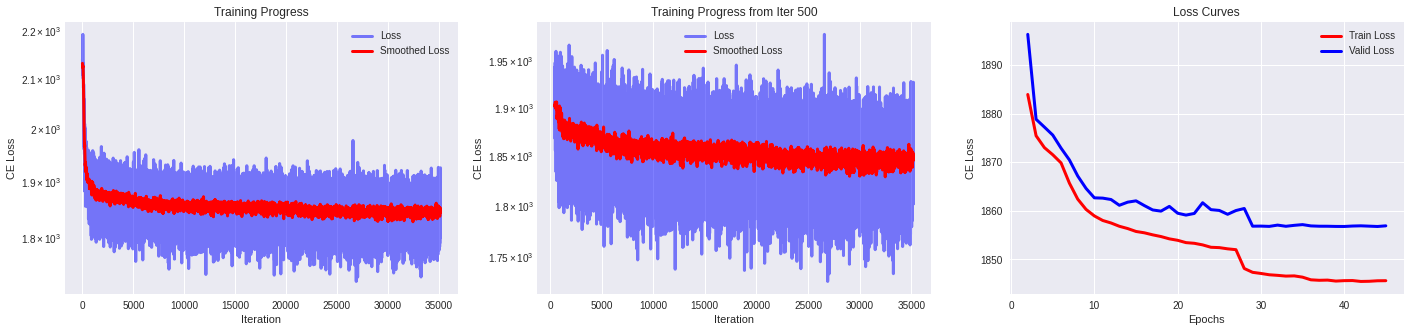

In [60]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,3)
fig.set_size_inches(24,5)

smooth_loss = smooth(filtered_loss_iters, 31)
ax[0].plot(filtered_loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_yscale("log")
ax[0].set_title("Training Progress")

smooth_loss = smooth(filtered_loss_iters, 31)
START = 500
N_ITERS = len(filtered_loss_iters)
ax[1].plot(np.arange(START, N_ITERS), filtered_loss_iters[START:], c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[1].plot(np.arange(START, N_ITERS), smooth_loss[START:], c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("CE Loss")
ax[1].set_yscale("log")
ax[1].set_title(f"Training Progress from Iter {START}")

epochs = np.arange(len(train_loss)) + 1
ax[2].plot(epochs[1:], train_loss[1:], c="red", label="Train Loss", linewidth=3)
ax[2].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("CE Loss")
ax[2].set_title("Loss Curves")


plt.show()

## As seen the model has a very large loss and it is decreasing rather very slowly .
### A bottleneck of size 2 was also used and it gave far worse results but as soon as the bottleneck size was increased to 10, the images started getting look better. With dimension of size 10 instead of 2, the images started to have some color in them and some shapes started to form. 

# Inference
## Images are attached to the e-mail

In [61]:
if not os.path.exists("imgs/inferecence_vae"):
    os.makedirs("imgs/inferecence_vae")

In [63]:
"""with torch.no_grad():
    for i in range(5):
        z = torch.randn(64, 2).to(device)
        sample = vae.decoder_lin(z)
        sample = vae.unflatten(sample)
        sample = vae.decoder(sample)
        save_image(sample.view(64, 1, 28, 28), f"imgs/inferecence_vae/inference_{i}.png")"""
with torch.no_grad():
    for i in range(5):
        z = torch.randn(64, 10).to(device)
        sample = vae.decode(z)
        save_image(sample.view(64, 3, 32, 32), f"imgs/inferecence_vae/inference_{i}.png")

In [64]:
imgs_flat, latents, labels = [], [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        _, (z, _, _) = model(imgs)
        imgs_flat.append(imgs.cpu().view(imgs.shape[0],-1))
        latents.append(z.cpu())
        labels.append(lbls)
        
imgs_flat = np.concatenate(imgs_flat)    
latents = np.concatenate(latents)
labels = np.concatenate(labels)

# Analysis

In [65]:
COLORS = ['r', 'b', 'g', 'y', 'purple', 'orange', 'k', 'brown', 'grey',
          'c', "gold", "fuchsia", "lime", "darkred", "tomato", "navy"]

def display_projections(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """
    
    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
    if(ax is None):
        _, ax = plt.subplots(1,1,figsize=(12,6))
    
    for i,l in enumerate(np.unique(labels)):
        idx = np.where(l==labels)

        ax.scatter(points[idx, 0], points[idx, 1], label=legend[int(l)], c=COLORS[i])
    ax.legend(loc="best")

In [66]:
pca_imgs = PCA(n_components=2).fit_transform(imgs_flat)
pca_latents = PCA(n_components=2).fit_transform(latents)

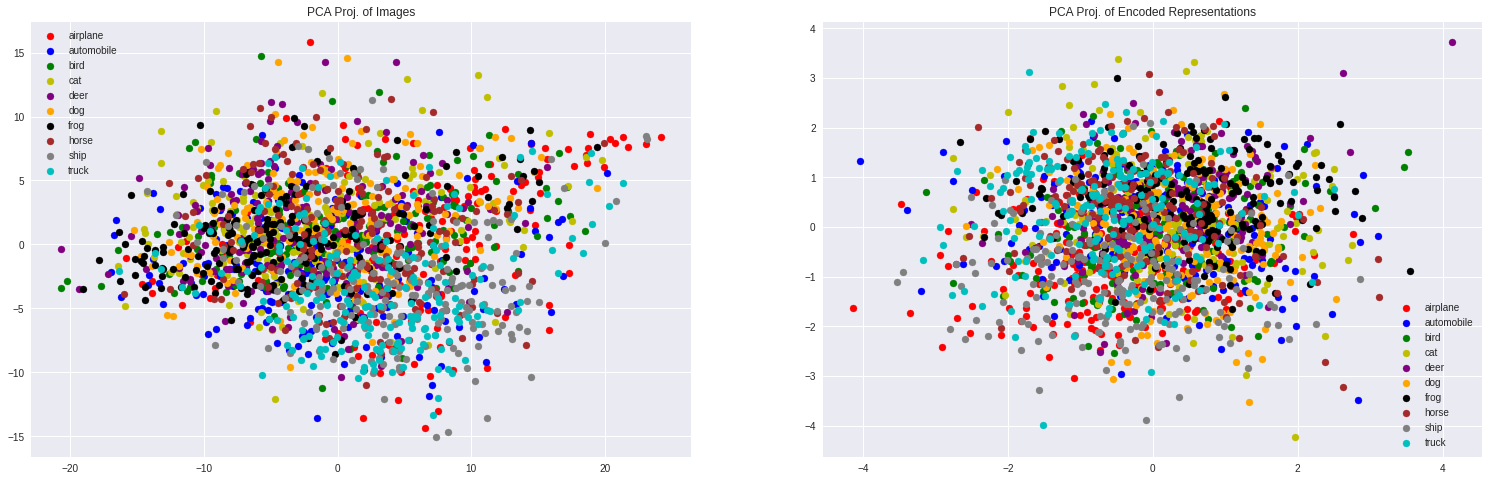

In [67]:
N = 2000
fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(pca_imgs[:N], labels[:N], ax=ax[0], legend=test_dataset.classes)
ax[0].set_title("PCA Proj. of Images")
display_projections(pca_latents[:N], labels[:N], ax=ax[1], legend=test_dataset.classes)
ax[1].set_title("PCA Proj. of Encoded Representations")
plt.show()

# Clustering

In [69]:
kmeans_imgs = KMeans(n_clusters=10, random_state=0).fit(imgs_flat)
kmeans_latent = KMeans(n_clusters=10, random_state=0).fit(latents)

In [70]:
ari_imgs = adjusted_rand_score(labels, kmeans_imgs.labels_)
ari_latents = adjusted_rand_score(labels, kmeans_latent.labels_)

In [71]:
print(f"Clustering images achieves  ARI={round(ari_imgs*100,2)}%")
print(f"Clustering latents achieves ARI={round(ari_latents*100,2)}%")

Clustering images achieves  ARI=4.32%
Clustering latents achieves ARI=5.27%


In [72]:
print(f"Compression ratio: {latents.shape[-1]}/{imgs_flat.shape[-1]}  = {round(latents.shape[-1]/imgs_flat.shape[-1] * 100, 2)}%")

Compression ratio: 10/3072  = 0.33%


### Bottleneck of size gives amazing compression ratio but is of no use as it fails to resconstruct images as far my experiment was concerned.

# Interpolation

In [73]:
@torch.no_grad()
def plot_reconstructed(model, xrange=(-3, 3), yrange=(-2, 2), N=12):
    """
    Sampling equispaced points from the latent space givent the xange and yrange, 
    decoding latents and visualizing distribution of the space
    """
    SIZE = 32
    grid = np.empty((3,N*SIZE, N*SIZE))
    
    for i, y in enumerate(np.linspace(*yrange, N)):
        for j, x in enumerate(np.linspace(*xrange, N)):
            z = torch.Tensor([[x,x,x,x,x, y,y,y,y,y]]).to(device)
            #print(z.shape)
            x_hat = model.decode(z).cpu()
            x_hat = x_hat.view(3,32,32)
            
            grid[:,(N-1-i)*SIZE:(N-i)*SIZE, j*SIZE:(j+1)*SIZE] = x_hat
    grid = np.transpose(grid,(1,2,0))
    print(grid.shape)       
    plt.figure(figsize=(12,20))
    plt.imshow(grid, extent=[*yrange, *xrange], cmap="gray")
    plt.axis("off")

(640, 640, 3)


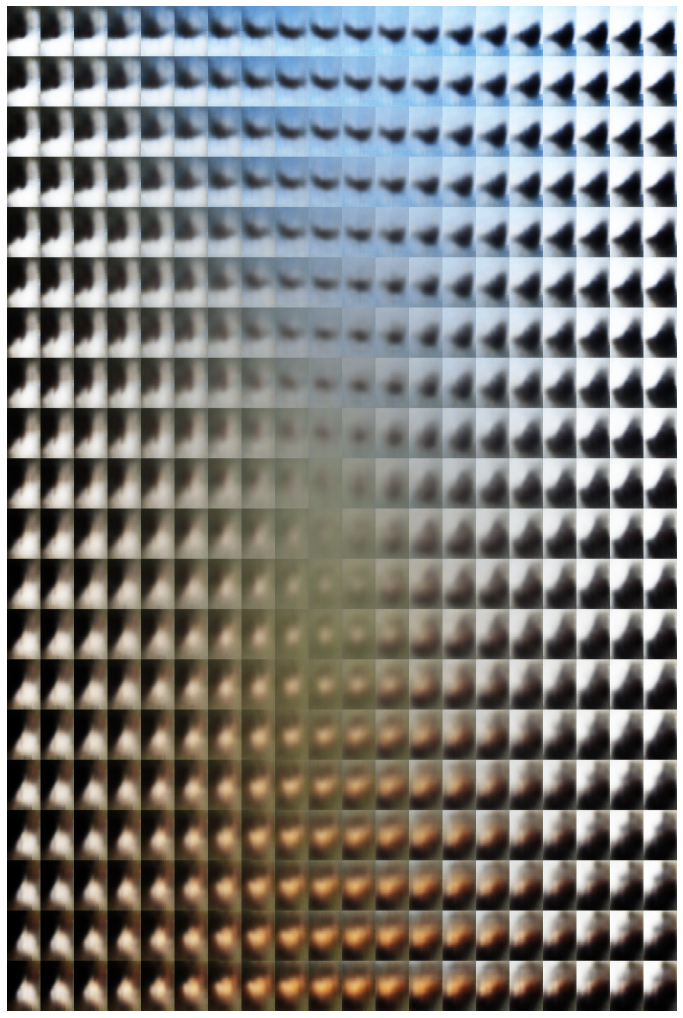

In [74]:
plot_reconstructed(model, xrange=(-3, 3), yrange=(-2, 2), N=20)

In [75]:
img1 = test_dataset[0][0]
img2 = test_dataset[13][0]

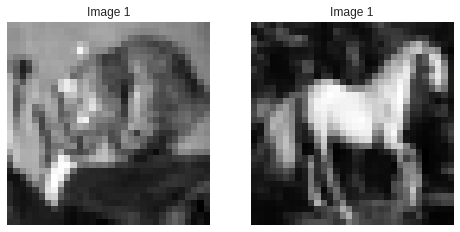

In [76]:
plt.subplot(1,2,1)
plt.imshow(img1[0], cmap="gray")
plt.axis("off")
plt.title(f"Image 1")
plt.subplot(1,2,2)
plt.imshow(img2[0], cmap="gray")
plt.axis("off")
plt.title(f"Image 1")
plt.show()

In [77]:
with torch.no_grad():
    encoded, mu, logvar = model.encode(torch.stack([img1, img2]).to(device))
    #mus, log_var = model.fc_mu(encoded), model.fc_sigma(encoded)
std = torch.exp(0.5*logvar)
latents = mu + std
latent1, latent2 = latents[0], latents[1]

In [78]:
print(latent1, latent2)

tensor([ 0.5758,  0.2726,  1.6886,  0.4170, -0.3296, -0.2792,  1.0907,  0.4828,
         0.1261,  0.1686], device='cuda:0') tensor([-1.3037,  1.0452,  1.7236, -1.6944, -0.1478, -2.1584, -1.8850,  0.6770,
        -0.8650,  1.2784], device='cuda:0')


In [79]:
@torch.no_grad()
def sample_interpolation(model, p1, p2, N=15):
    """ Sampling N points from the line that connects p1 and p2 """
    
    z = torch.stack([p1 * t + p2 * (1-t) for t in torch.linspace(0, 1, N).to(device)])
    decoded = model.decode(z)
    decoded_imgs = decoded.cpu().view(-1,32,32)
    return decoded_imgs

In [80]:
decoded_imgs = sample_interpolation(model, latent2, latent1, N=12)

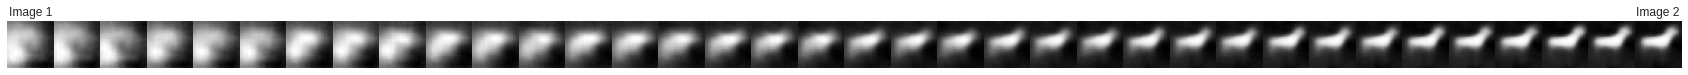

In [81]:
fig, ax = plt.subplots(1, len(decoded_imgs), figsize=(30,3))
for i,img in enumerate(decoded_imgs):
    ax[i].imshow(img, cmap="gray")
    ax[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.subplots_adjust(wspace=0., hspace=0)
ax[0].set_title("Image 1")
ax[-1].set_title("Image 2")
plt.show()

# As one can observe, the images seems to be slowly interpolating towards a horse.

# END of File